# PersistentDataset, CacheDataset, SmartCacheDataset and simple Dataset Tutorial and Speed Test

This tutorial shows how to accelerate PyTorch medical DL program based on
how data is loaded and preprocessed using different MONAI `Dataset` managers.

`Dataset` provides the simplest model of data loading.  Each time a dataset is needed, it is reloaded from the original datasources, and processed through the all non-random and random transforms to generate analyzable tensors. This mechanism has the smallest memory footprint, and the smallest temporary disk footprint.

`CacheDataset` provides a mechanism to pre-load all original data and apply non-random transforms into analyzable tensors loaded in memory prior to starting analysis.  The `CacheDataset` requires all tensor representations of data requested to be loaded into memory at once. The subset of random transforms is applied to the cached components before use. This is the highest performance dataset if all data fit in core memory.

`PersistentDataset` processes original data sources through the non-random transforms on first use, and stores these intermediate tensor values to an on-disk persistence representation.  The intermediate processed tensors are loaded from disk on each use for processing by the random-transforms for each analysis request.  The `PersistentDataset` has a similar memory footprint to the simple `Dataset`, with performance characteristics close to the `CacheDataset` at the expense of disk storage.  Additionally, the cost of first time processing of data is distributed across each first use.

It's modified from the [Spleen 3D segmentation tutorial notebook](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/acceleration/dataset_type_performance.ipynb)

## Setup environment

In [2]:
# I don't need to run the following 2 lines, already installed in MONAI Core v0.9.1 container, 
# !python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
# !python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob
import os
import pathlib
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    Dataset,
    DataLoader,
    PersistentDataset,
    SmartCacheDataset,
    decollate_batch,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 0.9.1
Numpy version: 1.22.4
Pytorch version: 1.13.0a0+340c412
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/scratch/local/47728021/tmpo5hp49o_


## Define a typical PyTorch training process

In [5]:
def train_process(train_ds, val_ds):
    # use batch_size=2 to load images and use RandCropByPosNegLabeld
    # to generate 2 x 4 images for network training
    train_loader = DataLoader(
        train_ds,
        batch_size=2,
        # batch_size=1,
        shuffle=True,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_ds, batch_size=1, num_workers=2
    )
    device = torch.device("cuda:0")
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

    max_epochs = 3
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()
    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"len(train_files) {len(train_files)},"
                f" len(train_ds) {len(train_ds)},"
                f" len(train_loader) {len(train_loader)},"
                f" train_loader.batch_size {train_loader.batch_size},"
                f" step/(len(train_ds)/train_loader.batch_size) {step}/{len(train_ds) // train_loader.batch_size},"
                f" step/(len(train_loader) - 1) {step}/{len(train_loader) - 1},"
                f" train_loss: {loss.item():.4f}"
                f" step time: {(time.time() - step_start):.4f}"
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model
                    )
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(
                        model.state_dict(),
                        os.path.join(root_dir, "best_metric_model.pth"),
                    )
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(
            f"time of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {(time.time() - total_start):.4f}"
    )
    return (
        max_epochs,
        time.time() - total_start,
        epoch_loss_values,
        metric_values,
        epoch_times,
    )

# Start of speed testing

The `PersistenceDataset`, `CacheDataset`, and `Dataset` are compared for speed for running 600 epochs.

## Download dataset

Downloads and extracts the dataset.
The dataset comes from http://medicaldecathlon.com/.

In [6]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [1:10:37, 380kB/s]                              

2022-09-21 23:16:56,891 - INFO - Downloaded: /scratch/local/47728021/tmpo5hp49o_/Task09_Spleen.tar


2022-09-21 23:16:59,473 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-09-21 23:16:59,474 - INFO - Writing into directory: /scratch/local/47728021/tmpo5hp49o_.


## Set MSD Spleen dataset path

In [7]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz"))
)
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz"))
)
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]
print(f"len(train_files) {len(train_files)}, len(val_files) {len(val_files)}")

len(train_files) 32, len(val_files) 9


## Setup transforms for training and validation

Deterministic transforms during training:
* LoadImaged
* EnsureChannelFirstd
* Spacingd
* Orientationd
* ScaleIntensityRanged

Non-deterministic transforms:
* RandCropByPosNegLabeld

All the validation transforms are deterministic.
The results of all the deterministic transforms will be cached to accelerate training.

In [8]:
def transformations():
    train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.5, 1.5, 2.0),
                mode=("bilinear", "nearest"),
            ),
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
            # randomly crop out patch samples from big
            # image based on pos / neg ratio
            # the image centers of negative samples
            # must be in valid image area
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
        ]
    )

    # NOTE: No random cropping in the validation data,
    # we will evaluate the entire image using a sliding window.
    val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.5, 1.5, 2.0),
                mode=("bilinear", "nearest"),
            ),
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-57,
                a_max=164,
                b_min=0.0,
                b_max=1.0,
                clip=True,
            ),
            CropForegroundd(keys=["image", "label"], source_key="image"),
        ]
    )
    return train_transforms, val_transforms

## Enable deterministic training and regular `Dataset`

Load each original dataset and transform each time it is needed.

In [9]:
set_determinism(seed=0)
train_trans, val_trans = transformations()
train_ds = Dataset(data=train_files, transform=train_trans)
val_ds = Dataset(data=val_files, transform=val_trans)

(
    max_epochs,
    total_time,
    epoch_loss_values,
    metric_values,
    epoch_times,
) = train_process(train_ds, val_ds)
print(
    f"total training time of {max_epochs} epochs"
    f" with regular Dataset: {total_time:.4f}"
)

----------
epoch 1/3
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 1/16, step/(len(train_loader) - 1) 1/15, train_loss: 0.6664 step time: 55.6309
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 2/16, step/(len(train_loader) - 1) 2/15, train_loss: 0.6870 step time: 0.5455
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 3/16, step/(len(train_loader) - 1) 3/15, train_loss: 0.6711 step time: 0.1381
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 4/16, step/(len(train_loader) - 1) 4/15, train_loss: 0.6910 step time: 0.1324
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 5

## Enable deterministic training and `PersistentDataset`

Use persistent storage of non-random transformed training and validation data computed once and stored in persistently across runs

In [10]:
persistent_cache = pathlib.Path(root_dir, "persistent_cache")
persistent_cache.mkdir(parents=True, exist_ok=True)

set_determinism(seed=0)
train_trans, val_trans = transformations()
train_persitence_ds = PersistentDataset(
    data=train_files, transform=train_trans, cache_dir=persistent_cache
)
val_persitence_ds = PersistentDataset(
    data=val_files, transform=val_trans, cache_dir=persistent_cache
)

(
    persistence_epoch_num,
    persistence_total_time,
    persistence_epoch_loss_values,
    persistence_metric_values,
    persistence_epoch_times,
) = train_process(train_persitence_ds, val_persitence_ds)
print(
    f"total training time of {persistence_epoch_num}"
    f" epochs with persistent storage Dataset: {persistence_total_time:.4f}"
)

----------
epoch 1/3
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 1/16, step/(len(train_loader) - 1) 1/15, train_loss: 0.6664 step time: 0.1306
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 2/16, step/(len(train_loader) - 1) 2/15, train_loss: 0.6870 step time: 0.1039
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 3/16, step/(len(train_loader) - 1) 3/15, train_loss: 0.6711 step time: 0.1233
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 4/16, step/(len(train_loader) - 1) 4/15, train_loss: 0.6910 step time: 0.1046
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 5/

## Enable deterministic training and `CacheDataset`

Precompute all non-random transforms of original data and store in memory.

In [11]:
set_determinism(seed=0)
train_trans, val_trans = transformations()
cache_init_start = time.time()
cache_train_ds = CacheDataset(
    # data=train_files, transform=train_trans, cache_rate=1.0, num_workers=2
    data=train_files, transform=train_trans, cache_rate=0.2, num_workers=2
)
cache_val_ds = CacheDataset(
    data=val_files, transform=val_trans, cache_rate=1.0, num_workers=2
)
cache_init_time = time.time() - cache_init_start

(
    cache_epoch_num,
    cache_total_time,
    cache_epoch_loss_values,
    cache_metric_values,
    cache_epoch_times,
) = train_process(cache_train_ds, cache_val_ds)
print(
    f"total training time of {cache_epoch_num}"
    f" epochs with CacheDataset: {cache_total_time:.4f}"
)

Loading dataset: 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]

----------
epoch 1/3


len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 1/16, step/(len(train_loader) - 1) 1/15, train_loss: 0.6664 step time: 0.1071
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 2/16, step/(len(train_loader) - 1) 2/15, train_loss: 0.6870 step time: 0.1047
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 3/16, step/(len(train_loader) - 1) 3/15, train_loss: 0.6711 step time: 0.1665
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 4/16, step/(len(train_loader) - 1) 4/15, train_loss: 0.6910 step time: 0.1314
len(train_files) 32, len(train_ds) 32, len(train_loader) 16, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 5/16, step/(len(train_l

## Enable deterministic training and `SmartCacheDataset`
The usage of SmartCacheDataset contains 4 steps:
  1. Initialize SmartCacheDataset object and cache for the first epoch.
  2. Call start() to run replacement thread in background.
  3. Call update_cache() before every epoch to replace training items.
  4. Call shutdown() when training ends.

In [12]:
def train_process_smartcache(train_ds, val_ds):
    # use batch_size=2 to load images and use RandCropByPosNegLabeld
    # to generate 2 x 4 images for network training
    train_loader = DataLoader(
        train_ds,
        batch_size=2,
        # batch_size=1,
        shuffle=True,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_ds, batch_size=1, num_workers=2
    )
    device = torch.device("cuda:0")
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)

    post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
    post_label = Compose([AsDiscrete(to_onehot=2)])

    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

    max_epochs = 3
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    epoch_times = []
    total_start = time.time()

    # start the replacement thread of SmartCache
    train_ds.start()

    for epoch in range(max_epochs):
        epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"len(train_files) {len(train_files)},"
                f" len(train_ds) {len(train_ds)},"
                f" len(train_loader) {len(train_loader)},"
                f" train_loader.batch_size {train_loader.batch_size},"
                f" step/(len(train_ds)/train_loader.batch_size) {step}/{len(train_ds) // train_loader.batch_size},"
                f" step/(len(train_loader) - 1) {step}/{len(train_loader) - 1},"
                f" train_loss: {loss.item():.4f}"
                f" step time: {(time.time() - step_start):.4f}"
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
        # replace % of cache content for next epoch
        train_ds.update_cache()        

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model
                    )
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(
                        model.state_dict(),
                        os.path.join(root_dir, "best_metric_model.pth"),
                    )
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(
            f"time of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}"
        )
        epoch_times.append(time.time() - epoch_start)

    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        f" total time: {(time.time() - total_start):.4f}"
    )
    # stop replacement thread of SmartCache
    train_ds.shutdown()
    
    return (
        max_epochs,
        time.time() - total_start,
        epoch_loss_values,
        metric_values,
        epoch_times,
    )

In [13]:
set_determinism(seed=0)
train_trans, val_trans = transformations()
smartcache_init_start = time.time()
smartcache_train_ds = SmartCacheDataset(
    data=train_files, 
    transform=train_trans, 
    replace_rate=1.0, 
    cache_rate=0.2,
    num_init_workers=2, 
    num_replace_workers=2,
)

smartcache_val_ds = SmartCacheDataset(
    data=val_files, 
    transform=val_trans, 
    replace_rate=1.0, 
    cache_rate=0.2,
    num_init_workers=2, 
    num_replace_workers=2,
)
smartcache_init_time = time.time() - smartcache_init_start

(
    smartcache_epoch_num,
    smartcache_total_time,
    smartcache_epoch_loss_values,
    smartcache_metric_values,
    smartcache_epoch_times,
) = train_process_smartcache(smartcache_train_ds, smartcache_val_ds)
print(
    f"total training time of {smartcache_epoch_num}"
    f" epochs with CacheDataset: {smartcache_total_time:.4f}"
)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

----------
epoch 1/3


len(train_files) 32, len(train_ds) 6, len(train_loader) 3, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 1/3, step/(len(train_loader) - 1) 1/2, train_loss: 0.6926 step time: 0.1631
len(train_files) 32, len(train_ds) 6, len(train_loader) 3, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 2/3, step/(len(train_loader) - 1) 2/2, train_loss: 0.6921 step time: 0.1408
len(train_files) 32, len(train_ds) 6, len(train_loader) 3, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 3/3, step/(len(train_loader) - 1) 3/2, train_loss: 0.6755 step time: 0.1906
epoch 1 average loss: 0.6867
saved new best metric model
current epoch: 1 current mean dice: 0.0300 best mean dice: 0.0300 at epoch: 1
time of epoch 1 is: 22.3302
----------
epoch 2/3
len(train_files) 32, len(train_ds) 6, len(train_loader) 3, train_loader.batch_size 2, step/(len(train_ds)/train_loader.batch_size) 1/3, step/(len(train_loader) - 1) 1/2, train_loss: 0.6975 step t

## Plot training loss and validation metrics

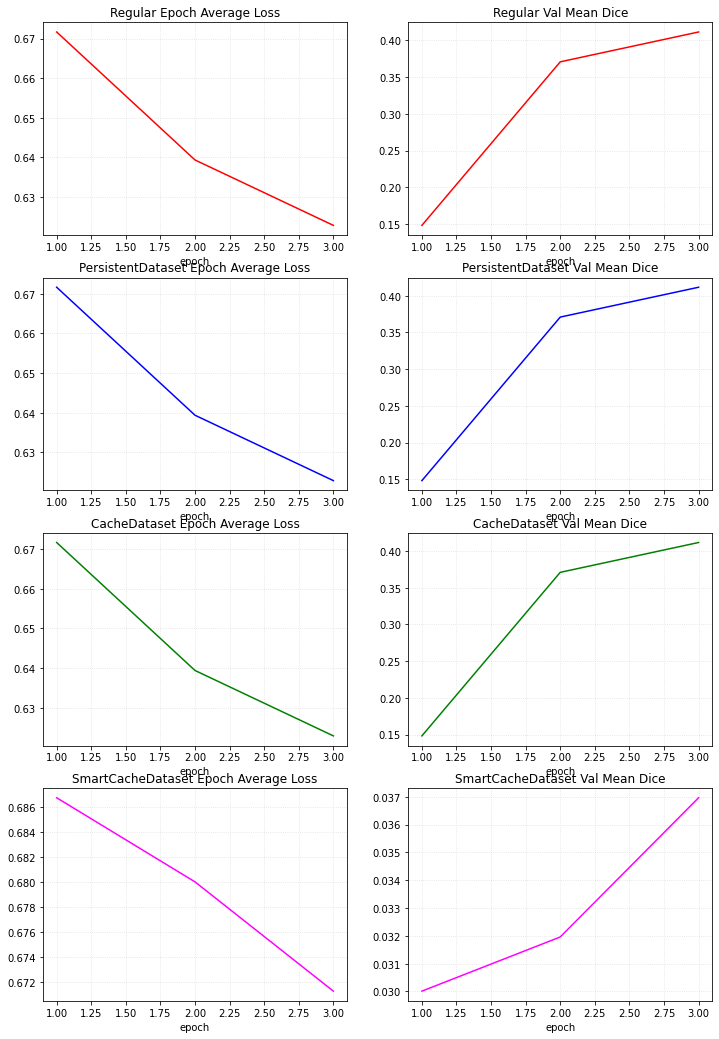

In [18]:
plt.figure("train", (12, 18))

plt.subplot(4, 2, 1)
plt.title("Regular Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(4, 2, 2)
plt.title("Regular Val Mean Dice")
x = [i + 1 for i in range(len(metric_values))]
y = cache_metric_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="red")

plt.subplot(4, 2, 3)
plt.title("PersistentDataset Epoch Average Loss")
x = [i + 1 for i in range(len(persistence_epoch_loss_values))]
y = persistence_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="blue")

plt.subplot(4, 2, 4)
plt.title("PersistentDataset Val Mean Dice")
x = [i + 1 for i in range(len(persistence_metric_values))]
y = persistence_metric_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="blue")

plt.subplot(4, 2, 5)
plt.title("CacheDataset Epoch Average Loss")
x = [i + 1 for i in range(len(cache_epoch_loss_values))]
y = cache_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")

plt.subplot(4, 2, 6)
plt.title("CacheDataset Val Mean Dice")
x = [i + 1 for i in range(len(cache_metric_values))]
y = cache_metric_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="green")

plt.subplot(4, 2, 7)
plt.title("SmartCacheDataset Epoch Average Loss")
x = [i + 1 for i in range(len(cache_epoch_loss_values))]
y = smartcache_epoch_loss_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="magenta")

plt.subplot(4, 2, 8)
plt.title("SmartCacheDataset Val Mean Dice")
x = [i + 1 for i in range(len(cache_metric_values))]
y = smartcache_metric_values
plt.xlabel("epoch")
plt.grid(alpha=0.4, linestyle=":")
plt.plot(x, y, color="magenta")

plt.show()

## Plot total time and every epoch time

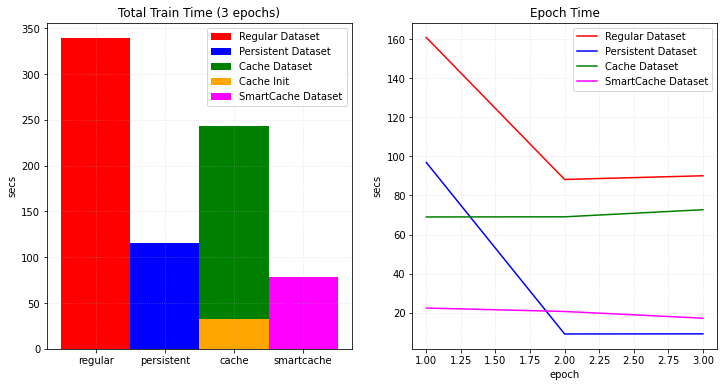

In [15]:
plt.figure("train", (12, 6))

plt.subplot(1, 2, 1)
plt.title("Total Train Time ({} epochs)".format(max_epochs))
plt.bar("regular", total_time, 1, label="Regular Dataset", color="red")
plt.bar(
    "persistent",
    persistence_total_time,
    1,
    label="Persistent Dataset",
    color="blue",
)
plt.bar(
    "cache",
    cache_init_time + cache_total_time,
    1,
    label="Cache Dataset",
    color="green",
)
plt.bar("cache", cache_init_time, 1, label="Cache Init", color="orange")
plt.bar(
    "smartcache",
    smartcache_total_time,
    1,
    label="SmartCache Dataset",
    color="magenta",
)
plt.ylabel("secs")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Epoch Time")
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel("epoch")
plt.ylabel("secs")
plt.plot(x, epoch_times, label="Regular Dataset", color="red")
plt.plot(x, persistence_epoch_times, label="Persistent Dataset", color="blue")
plt.plot(x, cache_epoch_times, label="Cache Dataset", color="green")
plt.plot(x, smartcache_epoch_times, label="SmartCache Dataset", color="magenta")
plt.grid(alpha=0.4, linestyle=":")
plt.legend(loc="best")

plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [16]:
if directory is None:
    shutil.rmtree(root_dir)